In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
pn.extension()

In [2]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters  # VideoOutputModeConfig, InteractivePlaceCellConfigs
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences

def debug_print_spike_counts(session):
    uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
    # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
    print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
    print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
    print(len(uniques)) # 69 
    uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
    # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
    print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
    print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
    
    print(len(uniques)) # 69 
    

In [26]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch, NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable

## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m

# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'

# ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

In [28]:
from neuropy.analyses import Pf1D, Pf2D, perform_compute_placefields, plot_all_placefields
from neuropy.plotting.spikes import get_neuron_colors

should_force_recompute_placefields = True
should_display_2D_plots = True

def compute_placefields_as_needed(active_session, computation_config=None, active_epoch_placefields1D = None, active_epoch_placefields2D = None, should_force_recompute_placefields=False, should_display_2D_plots=False):
    if computation_config is None:
        computation_config = PlacefieldComputationParameters(speed_thresh=9, grid_bin=2, smooth=0.5)
    active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_session.neurons, active_session.position, computation_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True)
    # Plot the placefields computed and save them out to files:
    if should_display_2D_plots:
        ax_pf_1D, occupancy_fig, active_pf_2D_figures = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config)
    else:
        print('skipping 2D placefield plots')
    return active_epoch_placefields1D, active_epoch_placefields2D

## Plotting Colors:
def build_units_colormap(session):
    pf_sort_ind = np.array([int(i) for i in np.arange(len(session.neuron_ids))]) # convert to integer scalar array
    pf_colors = get_neuron_colors(pf_sort_ind) # [4 x n_neurons]: colors are by ascending index ID
    pf_colormap = pf_colors.T # [n_neurons x 4] Make the colormap from the listed colors, used seemingly only by 'runAnalysis_PCAandICA(...)'
    pf_listed_colormap = ListedColormap(pf_colormap)
    return pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap

def process_by_good_placefields(session, active_config, active_placefields):
    """  Filters the session by the units in active_placefields that have good placefields and return an updated session. Also adds generated colors for each good unit to active_config """
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
    print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))

    ## Filter by neurons with good placefields only:
    good_placefields_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])

    pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(session)
    active_config.plotting_config.pf_sort_ind = pf_sort_ind
    active_config.plotting_config.pf_colors = pf_colors
    active_config.plotting_config.active_cells_colormap = pf_colormap
    active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)
    
    return good_placefields_session, active_config, good_placefield_neuronIDs


## For building the configs used to filter the session by epoch: 
def build_configs(session_config, active_epoch, active_subplots_shape = (1,1)):
    ## Get the config corresponding to this epoch/session settings:
    active_config = InteractivePlaceCellConfig(active_session_config=session_config, active_epochs=active_epoch, video_output_config=None, plotting_config=None) # '3|1    

    active_config.video_output_config = VideoOutputModeConfig(active_frame_range=np.arange(100.0, 120.0), 
                                                              video_output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name),
                                                              active_is_video_output_mode=False)
    active_config.plotting_config = PlottingConfig(output_subplots_shape=active_subplots_shape,
                                                   output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name)
                                                  )
    # Make the directories:
    active_config.plotting_config.active_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there
    return active_config


In [29]:
# KDiba Old Format:
sess = DataSessionLoader.kdiba_old_format_session(basedir)

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikes.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.laps_info.mat...
done.
setting laps object.
session.laps loaded successfully!
computing linear positions for all active epochs for session...
Saving updated position results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy...
2006-6-07_11-26-53.position.npy saved
done.

session.position linear positions computed!


In [30]:
active_sess_config = sess.config
session_name = sess.name
# Setup the placefield computation config
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=3, grid_bin=2, smooth=2)
sess.epochs.to_dataframe()

,start,stop,label,duration
0,0.000000,1739.153364,maze1,1739.153364
1,1739.153364,1932.420005,maze2,193.266641


In [31]:
# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\n session.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

session dataframe spikes: (932598, 19)
 session.neurons.n_spikes summed: 932598



## Debugging

In [25]:
# debug_print_spike_counts(sess)

# sess.spikes_df unique aclu values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
#  26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
#  50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
# sess.spikes_df unique aclu value counts: [    0     0  1707  1359   554  3066 91337  2707   294  2991   913  1278
#   1221  5475  2880 36760 48449   523  2595  3025 34729  3958  5263   790
#    663  1070  1078  2954  4044  2581 73951  4871 13444   476  1234 89854
#   5822 14961  2682  1184 13575 83972   795 22769  1559  8307  2098   438
#   3476 28370 43854  1355  2552  2875 59011  1440 75786  3656   875 17727
#  77247   550   408  2627  1734  2799]

# sess.spikes_df unique unit_id values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
#  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
#  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
# sess.spikes_df unique unit_id value counts: [ 1707  1359   554  3066 91337  2707   294  2991   913  1278  1221  5475
#   2880 36760 48449   523  2595  3025 34729  3958  5263   790   663  1070
#   1078  2954  4044  2581 73951  4871 13444   476  1234 89854  5822 14961
#   2682  1184 13575 83972   795 22769  1559  8307  2098   438  3476 28370
#  43854  1355  2552  2875 59011  1440 75786  3656   875 17727 77247   550
#    408  2627  1734  2799]

# sess.neurons.spiketrains
# sess.neurons.n_spikes

## Note the unit_id seems to have valid spikes for all of them, while the aclu does not!
sess.spikes_df # 1014937

sess.laps
# np.where(np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.maze_id == 2)))
# sess.spikes_df.lap.values[np.logical_and((sess.spikes_df.maze_relative_lap == 1), (sess.spikes_df.lap_maze == 2))]


# test_df = sess.spikes_df
# test_df

<Laps: {'_filename': None, '_metadata': None, 'lap_id': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]), 'laps_spike_counts': array([ 5497,  4028,  5573,  3641, 10843,  3249,  3462,  2995,  5448,
        3342,  4684,  2937,  4280,  3382,  4765,  6658,  3256,  3393,
        5314,  6533,  4353,  3284,  5972,  3315,  4330,  2920,  5829,
        3242,  5194,  3047,  8564,  3368,  4591,  3266,  6704,  3001,
        3891,  2706,  5008,  4926,  4808,  3724,  7136,  2197,  3087,
        2495,  3019,  2004,  2309,  2205,  4950,  2244,  3205,  2205,
        3200,  2189,  2512,  3177,  2583,  1949,  4644,  3091,  2467,
        2621,  2318,  2533,  6049,  3516,  4021,  1699,  3107,  1891,
      

In [ ]:
lap_specific_subsessions = list()
lap_grouped_spikes_df = sess.spikes_df.groupby(['lap']) #  as_index=False keeps the original index

In [ ]:
i = 2
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))
# lap_specific_subsessions.append(sess.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))

In [ ]:
i = 3
curr_lap_id = sess.laps.lap_id[i]
curr_lap_times = sess.laps.get_lap_times(i)
print('curr_lap_id: {}'.format(curr_lap_id))
print('curr_lap_times: {}'.format(curr_lap_times))

lap_specific_subsessions.append(sess.time_slice(curr_lap_times[0], curr_lap_times[-1]))

In [ ]:
lap_specific_session = DataSession.concat(lap_specific_subsessions)
lap_specific_session

In [ ]:
lap_specific_session.neurons.n_spikes # this looks right.

lap_specific_session.position.print_debug_str() # this looks right.

# len(sess.neurons.n_spikes) # 64 items long
# sess.neurons.n_spikes
# array([ 1707,  1359,   554,  3066, 91337,  2707,   294,  2991,   913,
#         1278,  1221,  5475,  2880, 36760, 48449,   523,  2595,  3025,
#        34729,  3958,  5263,   790,   663,  1070,  1078,  2954,  4044,
#         2581, 73951,  4871, 13444,   476,  1234, 89854,  5822, 14961,
#         2682,  1184, 13575, 83972,   795, 22769,  1559,  8307,  2098,
#          438,  3476, 28370, 43854,  1355,  2552,  2875, 59011,  1440,
#        75786,  3656,   875, 17727, 77247,   550,   408,  2627,  1734,
#         2799])



## Laps: Create version of Session that only includes activity during the laps

In [32]:
sess.laps.lap_id # 1-80

# np.unique(sess.spikes_df.lap)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [33]:
# lap_specific_session = sess.filtered_by_laps(np.arange(3, 80))
lap_specific_session = sess.filtered_by_laps()
print(lap_specific_session.neurons.n_spikes)

Constraining to epoch with times (start: 0.9605889999999999, end: 1.551483)
Constraining to epoch with times (start: 1.9044459999999999, end: 2.206307)
Constraining to epoch with times (start: 2.985211, end: 4.029979)
Constraining to epoch with times (start: 4.030028, end: 4.27442)
Constraining to epoch with times (start: 8.864488999999999, end: 9.316386)
Constraining to epoch with times (start: 9.821627, end: 10.039833)
Constraining to epoch with times (start: 23.766599, end: 24.650807999999998)
Constraining to epoch with times (start: 25.288679, end: 25.483893)
Constraining to epoch with times (start: 27.323957, end: 27.790944)
Constraining to epoch with times (start: 28.270063, end: 28.482695)
Constraining to epoch with times (start: 28.816122, end: 29.333389999999998)
Constraining to epoch with times (start: 30.092467, end: 30.286893)
Constraining to epoch with times (start: 31.053763, end: 31.259095)
Constraining to epoch with times (start: 31.627261999999998, end: 31.785574999999

# Filter Session by Epoch:

In [24]:
# active_epoch = sess.epochs.get_named_timerange('maze1')
active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])

active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right                                                   
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)                                  
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=9, grid_bin=2, smooth=0.5)

## All Spikes:
active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
## Lap_specific Spikes Only:
active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 1211.5580800310709, end: 2093.8978568242164)
0/1014937 total spikes spanning 70/108 units remain in subsession
Constraining to units with type: pyramidal
Constraining to epoch with times (start: 1211.5580800310709, end: 2093.8978568242164)
0/297183 total spikes spanning 70/108 units remain in subsession


In [12]:
print(sess.neurons.n_spikes)
print(active_lap_specific_epoch_session.neurons.n_spikes)

[  235   902   521  3465 60228  2845   586  3962  1493  1334 48712   280
  1843   426  1575  1875 45467   653 33885   396  1459   527   738   933
   248   911   728 16975 79907  1429  4175  1035  1509  3416  1519  2585
  2224  3315 38546  1840 26964 17665 18591  2292  1903 92936  7552  1990
  1783  1069  2004  1806  1055  2006  1668  2423   939  2841  2642  3351
  5160  2659  1499 65675  3247  1511  1357  1679  1137  1440  2901   447
  1252  4626  1185 72724  3365  1154 74260  1238   813  2871  1977  1408
  3434   396  2839  1817  2562  5025  1517  1355 38643  3113   847   810
  4654  1466  1604  3435  1870 32017 32190    63 42001  2784  6489   239]
[ 102  515  215  825  146  926  339   13  565  320  113    7  124  247
  684  590  178   79   11  706  305  471  503   37   62  531  941  912
  211  523  448  217  859  524  404  541  545  105  812 1154  344  803
  388  195  260 1298  193   80  395 2620  585 1778  251  529 2258 1152
 1646   21  929  255 1956  908  843  593  293  602  369   

## Compute Placefields if needed:

In [ ]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session.neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_config.plotting_config.active_cells_colormap)

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-08_14-26-15\maze1\1D Placefields - maze1.pdf"...
done.


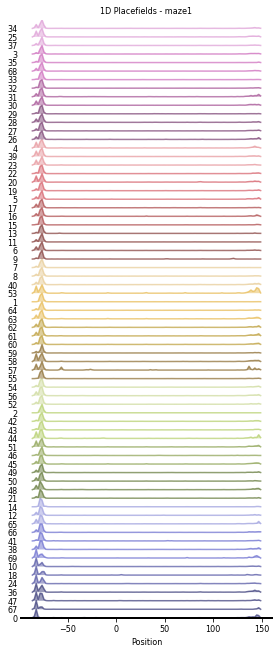

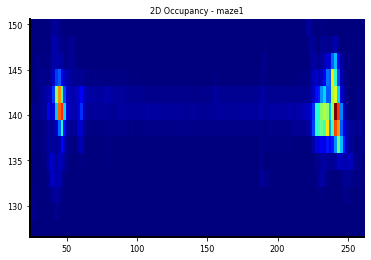

Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [  2   3   4   5   8  10  11  13  14  15  16  19  21  23  24  25  26  27
  28  31  32  33  34  36  37  41  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  66  67  68  69  70  73  74  75  76  78  81  82
  83  85  86  87  88  89  90  92  93  96  98 100 102 105 108 109]; (70 good)


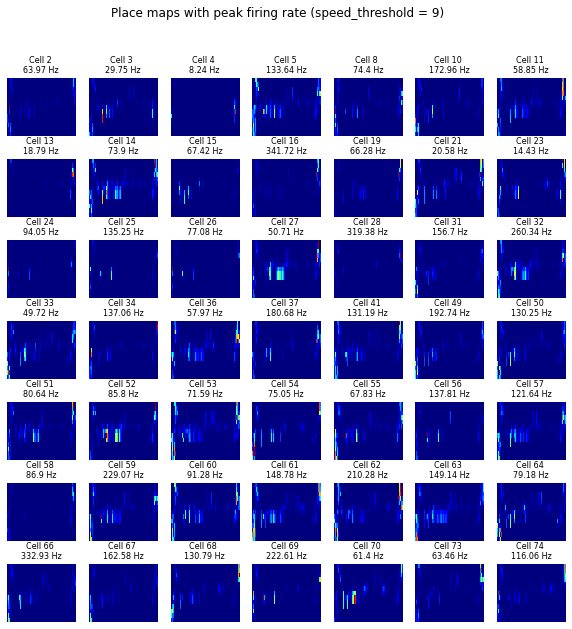

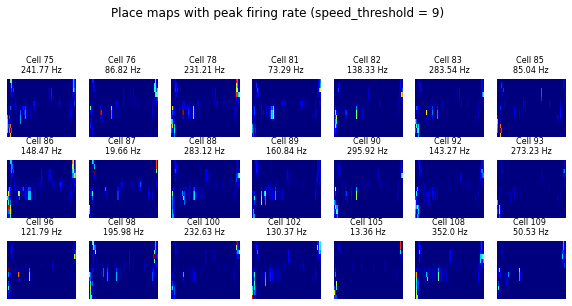

In [13]:
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_session, active_config.computation_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=should_force_recompute_placefields, should_display_2D_plots=should_display_2D_plots)
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the updated session using the units that have good placefields
active_epoch_session, active_config, good_placefield_neuronIDs = process_by_good_placefields(active_epoch_session, active_config, active_epoch_placefields)

## Compute the placefields for lap-only filtered Session:

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-08_14-26-15\maze1\1D Placefields - maze1.pdf"...
done.


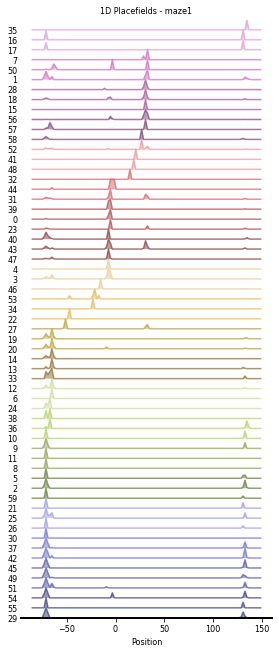

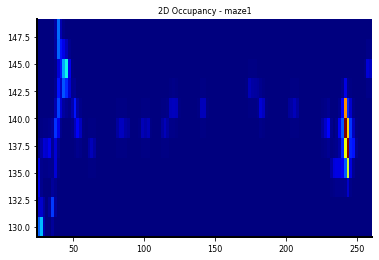

Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-08_14-26-15\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [  2   3   5   8  10  11  14  15  16  21  23  25  26  27  31  32  33  34
  36  37  41  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  66  67  68  69  70  73  74  75  76  78  81  82  83  85  86  88  89
  90  92  93  96  98 100 102 105 108 109]; (64 good)


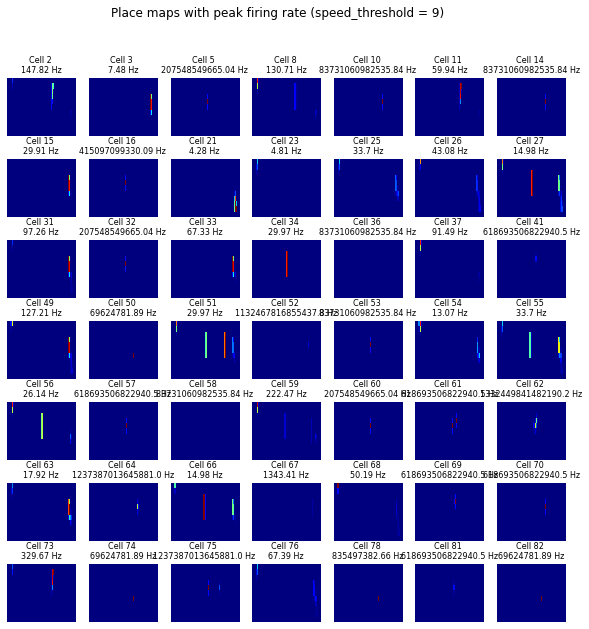

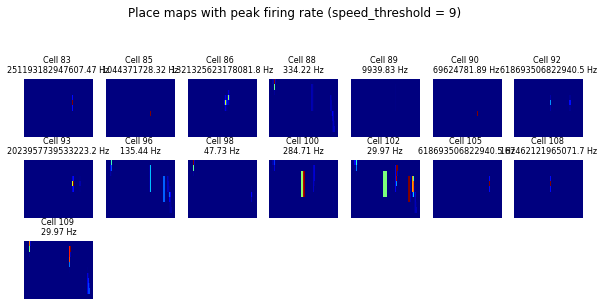

In [15]:
try: active_lap_only_placefields1D
except NameError: active_lap_only_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_lap_only_placefields2D
except NameError: active_lap_only_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

lap_specific_config = active_config
active_lap_only_placefields1D, active_lap_only_placefields2D = compute_placefields_as_needed(active_lap_specific_epoch_session, lap_specific_config.computation_config, active_lap_only_placefields1D, active_lap_only_placefields2D, should_force_recompute_placefields=should_force_recompute_placefields, should_display_2D_plots=True)
# Focus on the 2D placefields:
active_lap_only_placefields = active_lap_only_placefields2D
# Get the updated session using the units that have good placefields
lap_specific_session, lap_specific_config, lap_specific_good_placefield_neuronIDs = process_by_good_placefields(active_lap_specific_epoch_session, lap_specific_config, active_lap_only_placefields)

## Debug

In [16]:
debug_print_spike_counts(active_epoch_session)
# active_epoch_session.spikes_df unique aclu values: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
#  38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
# active_epoch_session.spikes_df unique aclu value counts: [   0    0  513  473   33  630    0  130  100  631   70  150  349    0
#    52    0    0  308  952    0    0 1436  898  342  223   89  109 1261
#   684  916    0    0    0  137  293    0    0    0  687  394    0    0
#   225    0  495 2123  316  111  396    0    0    0    0  458    0  576
#     0  927  382    0    0   89   90   55  370]
# active_epoch_session.spikes_df unique unit_id values: [ 0  1  2  3  5  6  7  8  9 10 12 15 16 19 20 21 22 23 24 25 26 27 31 32
#  36 37 40 42 43 44 45 46 51 53 55 56 59 60 61 62]
# active_epoch_session.spikes_df unique unit_id value counts: [ 513  473   33  630    0  130  100  631   70  150  349    0   52    0
#     0  308  952    0    0 1436  898  342  223   89  109 1261  684  916
#     0    0    0  137  293    0    0    0  687  394    0    0  225    0
#   495 2123  316  111  396    0    0    0    0  458    0  576    0  927
#   382    0    0   89   90   55  370]


# print(active_epoch_session.epochs.to_dataframe())
# print(sess.spikes_df) # max is in 4.2305 x 10^4
# print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4 ## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
# print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'
# # Get only the rows with a lap != -1:
# # spikes_df = spikes_df[(spikes_df.lap != -1)] # 229887 rows × 13 columns
# # spikes_df # 932598 rows × 14 columns

active_epoch_session.spikes_df unique aclu values: [  2.   3.   4.   5.   8.  10.  11.  13.  14.  15.  16.  19.  21.  23.
  24.  25.  26.  27.  28.  31.  32.  33.  34.  36.  37.  41.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  66.  67.  68.  69.  70.  73.  74.  75.  76.  78.  81.  82.  83.  85.
  86.  87.  88.  89.  90.  92.  93.  96.  98. 100. 102. 105. 108. 109.]
active_epoch_session.spikes_df unique aclu value counts: [ 235  902  521 3465  586 1493 1334  280 1843  426 1575  653  396  527
  738  933  248  911  728 1429 4175 1035 1509 1519 2585 1840 1990 1783
 1069 2004 1806 1055 2006 1668 2423  939 2841 2642 3351 5160 2659 1499
 3247 1511 1357 1679 1137  447 1252 4626 1185 3365 1238  813 2871 1408
 3434  396 2839 1817 2562 1517 1355  847 4654 1604 1870   63 6489  239]
70
active_epoch_session.spikes_df unique unit_id values: [  0   1   2   3   6   8   9  11  12  13  14  17  19  21  22  23  24  25
  26  29  30  31  32  34  35  39  47  48  49  50  

In [ ]:
print('pix2cm: {}'.format(DataSessionLoader.pix2cm))

In [17]:
active_epoch_session.spikes_df

,t,t_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,linear_pos,unit_id
2,187.0,0.000187,8.0,19.0,62.0,4.0,231.393024,139.660200,0.000000,0.0,-1.0,-1.0,1.0,NeuronType.PYRAMIDAL,2,NaN,NaN,NaN,60
6,300.0,0.000300,2.0,6.0,8.0,2.0,231.393024,139.660200,0.000000,0.0,-1.0,-1.0,1.0,NeuronType.PYRAMIDAL,6,NaN,NaN,NaN,6
17,743.0,0.000743,8.0,19.0,62.0,4.0,231.393024,139.660200,0.000000,0.0,-1.0,-1.0,1.0,NeuronType.PYRAMIDAL,17,NaN,NaN,NaN,60
20,1048.0,0.001048,8.0,10.0,58.0,2.0,231.393024,139.660200,0.000000,0.0,-1.0,-1.0,1.0,NeuronType.PYRAMIDAL,20,0.805908,0.493603,NaN,56
22,1060.0,0.001060,9.0,3.0,70.0,2.0,231.393024,139.660200,0.000000,0.0,-1.0,-1.0,1.0,NeuronType.PYRAMIDAL,22,0.805887,0.493577,NaN,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014914,68623619.0,68.623619,7.0,15.0,50.0,2.0,242.301711,140.880738,0.089909,0.0,-1.0,-1.0,2.0,NeuronType.PYRAMIDAL,1014914,NaN,NaN,NaN,48
1014926,68624038.0,68.624038,8.0,22.0,64.0,2.0,242.301702,140.880727,0.087523,0.0,-1.0,-1.0,2.0,NeuronType.PYRAMIDAL,1014926,NaN,NaN,NaN,62
1014927,68624061.0,68.624061,3.0,17.0,33.0,1.0,242.301702,140.880727,0.087392,0.0,-1.0,-1.0,2.0,NeuronType.PYRAMIDAL,1014927,NaN,NaN,NaN,31
1014931,68624207.0,68.624207,9.0,8.0,74.0,2.0,242.301699,140.880723,0.086561,0.0,-1.0,-1.0,2.0,NeuronType.PYRAMIDAL,1014931,NaN,NaN,NaN,72


In [18]:
debug_print_spike_counts(active_epoch_session) # 46 neurons after filtering, much better

# count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'])
# count_arr
valid_indicies = np.nonzero(active_epoch_session.spikes_df['unit_id'].values)
valid_indicies
# count_arr = np.bincount(active_epoch_session.spikes_df['aclu'])
# count_arr

# len(active_epoch_session.spikes_df['unit_id'].values) # 17766
active_epoch_session.neurons.n_spikes

# active_epoch_session.neurons.n_spikes # array([ 513,  473,   33,  630,  130,  631,  150,  349,  308,  952, 1436,
#         # 898,  342,  223, 1261,  684,  916,  137,  293,  687,  394,  225,
#         # 495, 2123,  316,  111,  396,  458,  576,  927,  382])
        
# array([   0,    0,  513,  473,   33,  630,    0,  130,    0,  631,    0,
#         150,  349,    0,    0,    0,    0,  308,  952,    0,    0, 1436,
#         898,  342,  223,    0,    0, 1261,  684,  916,    0,    0,    0,
#         137,  293,    0,    0,    0,  687,  394,    0,    0,  225,    0,
#         495, 2123,  316,  111,  396,    0,    0,    0,    0,  458,    0,
#         576,    0,  927,  382], dtype=int64)

active_epoch_session.spikes_df unique aclu values: [  2.   3.   4.   5.   8.  10.  11.  13.  14.  15.  16.  19.  21.  23.
  24.  25.  26.  27.  28.  31.  32.  33.  34.  36.  37.  41.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  66.  67.  68.  69.  70.  73.  74.  75.  76.  78.  81.  82.  83.  85.
  86.  87.  88.  89.  90.  92.  93.  96.  98. 100. 102. 105. 108. 109.]
active_epoch_session.spikes_df unique aclu value counts: [ 235  902  521 3465  586 1493 1334  280 1843  426 1575  653  396  527
  738  933  248  911  728 1429 4175 1035 1509 1519 2585 1840 1990 1783
 1069 2004 1806 1055 2006 1668 2423  939 2841 2642 3351 5160 2659 1499
 3247 1511 1357 1679 1137  447 1252 4626 1185 3365 1238  813 2871 1408
 3434  396 2839 1817 2562 1517 1355  847 4654 1604 1870   63 6489  239]
70
active_epoch_session.spikes_df unique unit_id values: [  0   1   2   3   6   8   9  11  12  13  14  17  19  21  22  23  24  25
  26  29  30  31  32  34  35  39  47  48  49  50  

array([ 235,  902,  521, 3465,  586, 1493, 1334,  280, 1843,  426, 1575,
        653,  396,  527,  738,  933,  248,  911,  728, 1429, 4175, 1035,
       1509, 1519, 2585, 1840, 1990, 1783, 1069, 2004, 1806, 1055, 2006,
       1668, 2423,  939, 2841, 2642, 3351, 5160, 2659, 1499, 3247, 1511,
       1357, 1679, 1137,  447, 1252, 4626, 1185, 3365, 1238,  813, 2871,
       1408, 3434,  396, 2839, 1817, 2562, 1517, 1355,  847, 4654, 1604,
       1870,   63, 6489,  239])

In [20]:
active_lap_specific_epoch_session.spikes_df

,t,t_seconds,shank,cluster,aclu,qclu,x,y,speed,traj,lap,maze_relative_lap,maze_id,cell_type,flat_spike_idx,x_loaded,y_loaded,linear_pos,unit_id
83440,5251380.0,5.251380,12.0,6.0,100.0,4.0,260.058901,146.120711,14.660070,7.0,4.0,4.0,1.0,NeuronType.PYRAMIDAL,83440,0.137983,0.514014,NaN,98
83449,5251763.0,5.251763,12.0,6.0,100.0,4.0,260.057188,146.115022,14.678747,7.0,4.0,4.0,1.0,NeuronType.PYRAMIDAL,83449,0.137994,0.513953,NaN,98
83480,5255211.0,5.255211,10.0,2.0,82.0,2.0,260.041770,146.063807,14.846894,7.0,4.0,4.0,1.0,NeuronType.PYRAMIDAL,83480,0.138334,0.514304,NaN,80
83533,5258916.0,5.258916,12.0,9.0,102.0,4.0,260.025201,146.008775,15.027573,7.0,4.0,4.0,1.0,NeuronType.PYRAMIDAL,83533,0.141112,0.516380,NaN,100
83542,5259822.0,5.259822,12.0,6.0,100.0,4.0,260.021150,145.995317,15.071756,7.0,4.0,4.0,1.0,NeuronType.PYRAMIDAL,83542,0.141614,0.515895,NaN,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990729,67298795.0,67.298795,8.0,7.0,56.0,4.0,242.572232,140.695456,0.252871,1.0,80.0,40.0,2.0,NeuronType.PYRAMIDAL,990729,0.731025,0.488313,NaN,54
990730,67298861.0,67.298861,8.0,26.0,67.0,4.0,242.572219,140.695465,0.252871,1.0,80.0,40.0,2.0,NeuronType.PYRAMIDAL,990730,0.731027,0.488303,NaN,65
990732,67298958.0,67.298958,8.0,3.0,53.0,4.0,242.572198,140.695479,0.252872,1.0,80.0,40.0,2.0,NeuronType.PYRAMIDAL,990732,0.731029,0.488289,NaN,51
990746,67299886.0,67.299886,8.0,25.0,66.0,4.0,242.572005,140.695612,0.252887,1.0,80.0,40.0,2.0,NeuronType.PYRAMIDAL,990746,0.731063,0.488042,NaN,64


## Main Spike/Placemap plotting:

# Plot Placemaps on 3D Plot

## Tuning Curves 3D Plot:

In [ ]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

## Debugging Index Issues:

In [ ]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
# test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

# test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData


unique_ids = np.unique(test_full_pc_data['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# count_arr = np.bincount(test_full_pc_data['cellID'])
count_arr
# array([ 3591,  3311,   231,  4410,     0,   910,     0,  4417,     0,
#         1050,  2443,     0,     0,     0,     0,  2156,  6664,     0,
#            0, 10052,  6286,  2394,  1561,     0,     0,  8827,  4788,
#         6412,     0,     0,     0,   959,  2051,     0,     0,     0,
#         4809,  2758,     0,     0,  1575,     0,  3465, 14861,  2212,
#          777,  2772,     0,     0,     0,     0,  3206,     0,  4032,
#            0,  6489,  2674], dtype=int64)

# good_placefield_neuronIDs: [  5   8  10  13  14  16  19  21  23  25  28  31  32  33  36  37  41  49
#   52  53  54  55  57  59  60  61  62  63  64  66  68  69  74  75  76  78
#   83  86  88  89  90  92  96  98 105 108]; (46 good)

# 1, 4, 6, 7, 8, 11, 18, 19, 21 ## CONCLUSION: the ones that work are indeed the non-zero entries, but the checkboxes work in reverse order to this array that's printed. Meaning you start at the end and work back.
# len(count_arr) # 107
print(unique_ids) # [  3   6   8  11  12  14  17  19  21  23  26  29  30  31  34  35  39  47
  # 50  51  52  53  55  57  58  59  60  61  62  64  66  67  72  73  74  76
  # 81  84  86  87  88  90  94  96 103 106]


# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['aclu'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['aclu'].values)
# print('active_epoch_session.spikes_df unique aclu values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique aclu value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 
# uniques, indicies, inverse_indicies, count_arr = np.unique(active_epoch_session.spikes_df['unit_id'].values, return_index=True, return_inverse=True, return_counts=True)
# # count_arr = np.bincount(active_epoch_session.spikes_df['unit_id'].values)
# print('active_epoch_session.spikes_df unique unit_id values: {}'.format(uniques))
# print('active_epoch_session.spikes_df unique unit_id value counts: {}'.format(count_arr))
# print(len(uniques)) # 46 

In [ ]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([38], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53], True) # seems to work

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([44, 53], True) # seems to work

# test_subset
# test_subset

In [ ]:
ipcDataExplorer.update_placefield_spike_visibility([53, 44], False) # seems to work

In [ ]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

In [ ]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

In [ ]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


## Interactive 3D Spike and Behavior Browser: 

In [21]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

active_epoch_pos.sampling_rate (Hz): 29.96977250291495
longer_spikes_window - curr_view_window_length_samples - 30689
recent_spikes_window - curr_view_window_length_samples - 299
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter
[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D


# Programmatically change the animal position trail:

In [ ]:
def plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces):
    num_lap_samples = np.shape(curr_lap_position_traces)[1]
    lap_fixed_z = np.full_like(curr_lap_position_traces[0,:], 0.9)
    plot_name = 'lap_location_trail'
    # fade_values = ipspikesDataExplorer.params.active_trail_opacity_values
    # size_values = ipspikesDataExplorer.params.active_trail_size_values
    trail_fade_values = None
    size_values = None
    # trail_fade_values = np.linspace(0.0, 0.6, num_lap_samples)
    size_values = np.linspace(0.2, 0.6, num_lap_samples) # fade from a scale of 0.2 to 0.6
    ipspikesDataExplorer.perform_plot_location_trail(plot_name, curr_lap_position_traces[0,:], curr_lap_position_traces[1,:], lap_fixed_z,
                                                 trail_fade_values=trail_fade_values, trail_point_size_values=size_values,
                                                 render=True, color='red')

# def hide_lap_trajectory_path(ipspikesDataExplorer):
    



    
## ACTIVE: Laps and Spikes:

# def visually_indicate_current_lap(
curr_lap_id = 0

curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

curr_lap_num_spikes = len(curr_lap_spike_indicies)
print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

test_flat_times = active_epoch_session.flattened_spiketrains.flattened_spike_times
print(test_flat_times)
    
plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showing/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

In [ ]:
renderWindow.SetWindowName('Test')
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
# ipspikesDataExplorer.spikes_main_historical.SetVisibility(0)

# ipspikesDataExplorer.spikes_main_historical.SetVisibility(1)
# bool(ipspikesDataExplorer.spikes_main_historical.GetVisibility())

ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# toggle_visibility(ipspikesDataExplorer.spikes_main_historical)

In [ ]:
ipspikesDataExplorer.toggle_plot_visibility('lap_location_trail')

In [ ]:
# ipspikesDataExplorer.spikes_main_recent_only.SetVisibility(True)
toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_location_trail)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

# Programmatically change the animals location point indicator:

In [ ]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_poin

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice